In [23]:
from xflow.extensions.physics.beam import extract_beam_parameters
from xflow.utils.io import scan_files
from xflow.utils.decorator import with_progress
from xflow.data.transform import split_width
from xflow.utils.visualization import plot_image

import matplotlib.pyplot as plt
import cv2

dir = ["/Users/andrewxu/Documents/DataHub/datasets/2025-11-19/dataset/12",
       "/Users/andrewxu/Documents/DataHub/datasets/2025-11-19/dataset/11",
       "/Users/andrewxu/Documents/DataHub/datasets/2025-11-19/dataset/10"]

image_paths = []
for d in dir:
    image_paths.extend(scan_files(d, extensions='.png', return_type='str'))

@with_progress
def run_beam_extraction(image_paths):
    """
    image_paths: list of file paths (str or Path)
    returns: list of whatever extract_beam_parameters returns
    """
    results = []
    for path in image_paths:
        img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue  # skip unreadable images
        l, r = split_width(img)
        params = extract_beam_parameters(l)
        if not params:
            continue
        results.append(params)
    return results

all_params = run_beam_extraction(image_paths)

100%|██████████| 2627/2627 [00:24<00:00, 106.71it/s]


In [49]:
import numpy as np

def find_best_square(all_params, square_size=0.25, scale=1):
    """
    all_params: list of [h_centroid, v_centroid, h_width, v_width]
    square_size: side length of the square in normalized [0,1] units

    Returns:
        {
            "top_left": (x_min, y_max),
            "bottom_right": (x_max, y_min),
            "count": number_of_points_inside
        }
    """
    if not all_params:
        return None

    L = float(square_size)
    if L <= 0 or L > 1:
        raise ValueError("square_size must be in (0, 1].")

    pts = np.array([[p[0], p[1]] for p in all_params], dtype=float)
    x = np.clip(pts[:, 0], 0.0, 1.0)
    y = np.clip(pts[:, 1], 0.0, 1.0)

    eps = 1e-12
    candidate_x = set()

    # candidate left edges from points and (point - L), all clipped into [0, 1-L]
    for xi in x:
        candidate_x.add(float(np.clip(xi,     0.0, 1.0 - L)))
        candidate_x.add(float(np.clip(xi - L, 0.0, 1.0 - L)))

    candidate_x.add(0.0)
    candidate_x.add(1.0 - L)
    candidate_x = sorted(candidate_x)

    best_count = -1
    best_x0 = 0.0
    best_y0 = 0.0

    for x0 in candidate_x:
        x1 = x0 + L + eps
        mask = (x >= x0) & (x <= x1)
        ys = y[mask]
        if ys.size == 0:
            continue

        ys_sorted = np.sort(ys)
        a = 0
        for b in range(ys_sorted.size):
            # shrink window from bottom until height <= L
            while ys_sorted[b] - ys_sorted[a] > L + eps:
                a += 1

            # window ys_sorted[a:b+1] fits in height <= L
            y0_candidate = ys_sorted[a]
            # if near top border, clamp so square stays inside [0,1]
            if y0_candidate + L > 1.0:
                y0_candidate = 1.0 - L

            count = b - a + 1
            if count > best_count:
                best_count = count
                best_x0 = x0
                best_y0 = y0_candidate

    x_min = best_x0
    y_min = best_y0
    x_max = min(best_x0 + L, 1.0)
    y_max = min(best_y0 + L, 1.0)

    return {
        "top_left": (x_min * scale, y_max * scale),
        "bottom_right": (x_max * scale, y_min * scale),
        "count": int(best_count)
    }

best_square = find_best_square(all_params, square_size=0.33, scale=1)
print(best_square["top_left"], best_square["bottom_right"], best_square["count"])

(0.3087198555956881, np.float64(0.7136596045476417)) (0.6387198555956881, np.float64(0.38365960454764164)) 1155


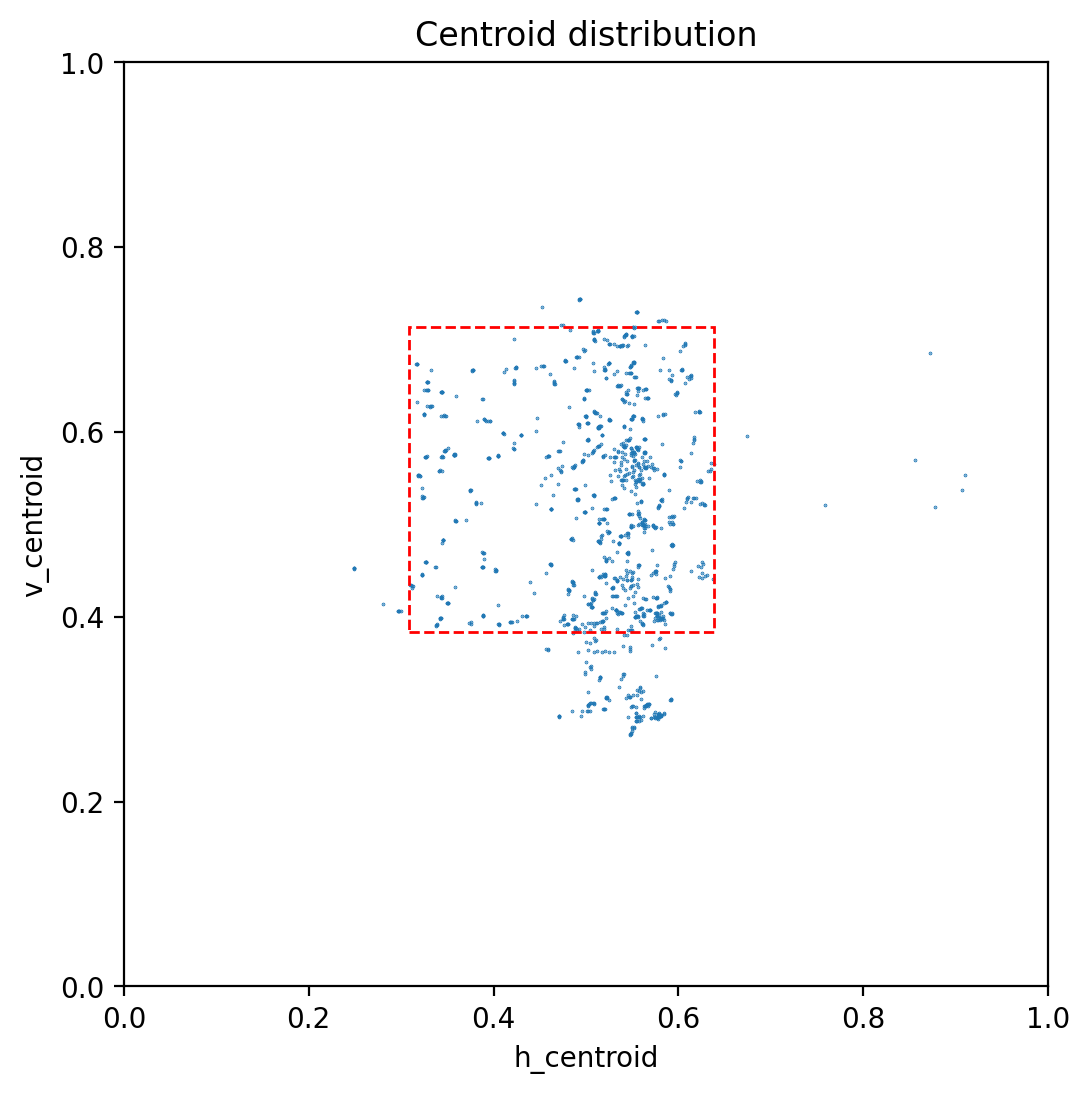

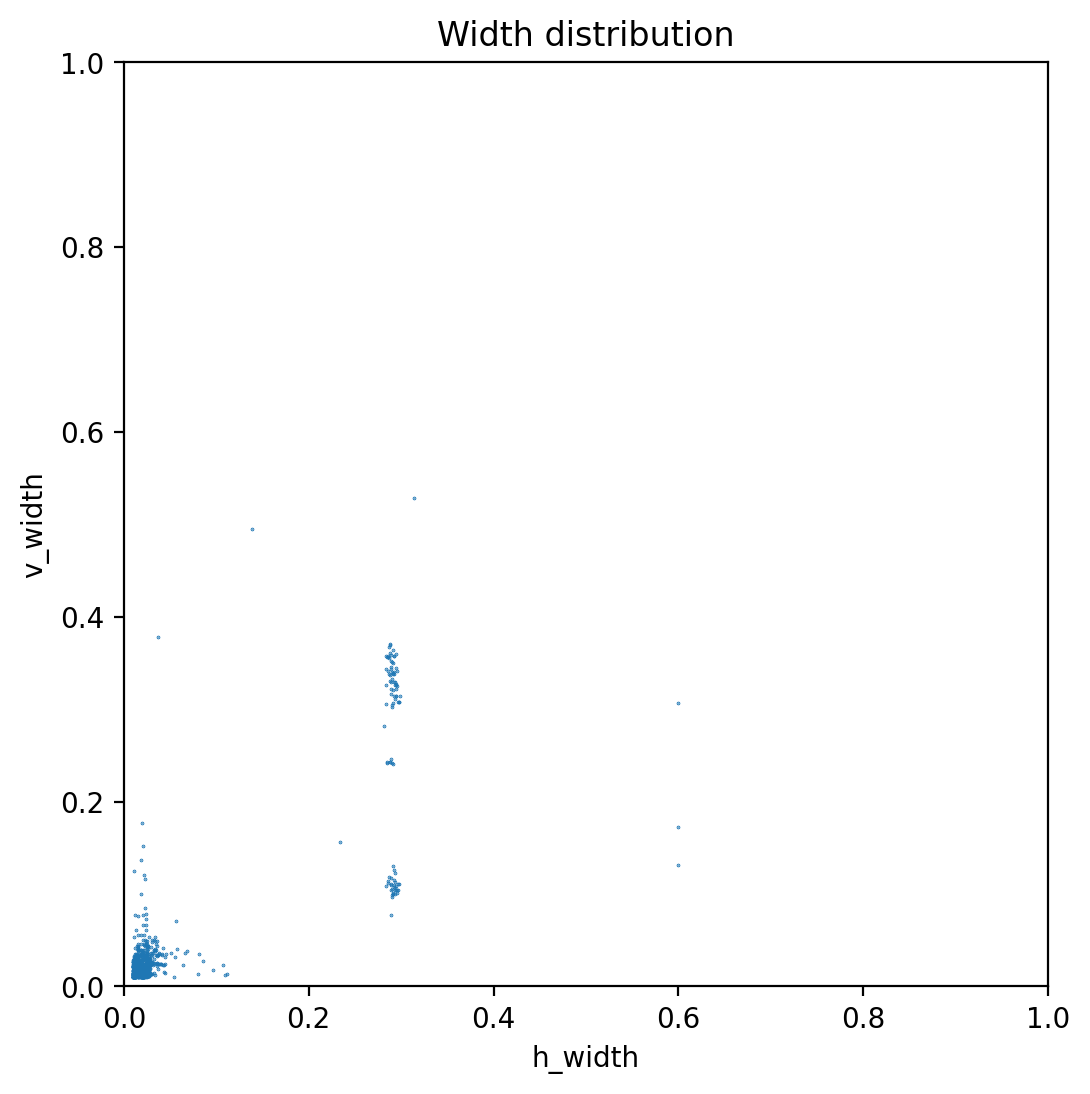

In [47]:

import matplotlib.pyplot as plt

def plot_beam_parameters(
    all_params,
    point_size=1,
    top_left=None,
    bottom_right=None,
    dpi=200,           # <--- new arg
    figsize=(5, 5),    # <--- optional
):
    """
    all_params: list of [h_centroid, v_centroid, h_width, v_width]
    top_left: (x_min, y_max) in normalized [0,1] coordinates
    bottom_right: (x_max, y_min) in normalized [0,1] coordinates
    """

    h_centroid = [p[0] for p in all_params]
    v_centroid = [p[1] for p in all_params]
    h_width    = [p[2] for p in all_params]
    v_width    = [p[3] for p in all_params]

    # 1) Centroid distribution
    fig1, ax1 = plt.subplots(figsize=figsize, dpi=dpi)
    ax1.scatter(h_centroid, v_centroid, s=point_size)
    ax1.set_xlabel("h_centroid")
    ax1.set_ylabel("v_centroid")
    ax1.set_title("Centroid distribution")
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_aspect('equal', adjustable='box')

    if top_left is not None and bottom_right is not None:
        x_min, y_max = top_left
        x_max, y_min = bottom_right
        width  = x_max - x_min
        height = y_max - y_min

        rect = plt.Rectangle(
            (x_min, y_min), width, height,
            fill=False,
            linestyle='--',
            edgecolor='red'
        )
        ax1.add_patch(rect)

    # 2) Width distribution
    fig2, ax2 = plt.subplots(figsize=figsize, dpi=dpi)
    ax2.scatter(h_width, v_width, s=point_size)
    ax2.set_xlabel("h_width")
    ax2.set_ylabel("v_width")
    ax2.set_title("Width distribution")
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.set_aspect('equal', adjustable='box')

    plt.show()



plot_beam_parameters(
    all_params,
    point_size=0.1,
    top_left=best_square["top_left"],
    bottom_right=best_square["bottom_right"],
    dpi=200,
    figsize=(6,6)
)